# Übung 10

**Gruppenname:**

*TLJ*

Christian Rene Thelen, Artur Less, Karl Johannes

### 10.1 Least Squares Support Vector Machine (LS-SVM)

In der Vorlesung haben Sie die LS-SVM als eine Variante der Support Vector Machine (SVM) kennengelernt, die sich einfacher implementieren lässt. Sie werden im Rahmen dieser Übung die LS-SVM mit einem Gaußschen RBF-Kernel implementieren und testen. Nutzen Sie für die Implementierung Befehle der Numpy-Bibliothek.

**Ihre Aufgaben**

(1) Schlagen Sie in den Vorlesungsfolien nach, wie die LS-SVM zu implementieren ist: Identifizieren Sie die 5 Schritte, die Sie für die Implementierung durchführen müssen.

Zusammenfassend lässt sich das Vorgehen für die Least Squares Support Vector Machine wie folgt beschreiben:
1. Implementieren der Funktion $$ 
K_{k,i} = K(x, x') = \exp\left( - \frac{|| x - x' ||^2}{2\sigma^2} \right) = \exp\left( - \gamma || x - x' ||^2 \right)  
$$
2. Bestimme die $N\times N$-Matrix $\Omega = yy^T \odot K$, wobei $y$ der Vektor der Trainingsdatenlabels und $K$ die $N\times N$-Kernelmatrix ist.
3. Bestimme die Matrix $$
	A = \left[\begin{array}{c|c}
	0 &  y^T\\ \hline
	y & \Omega + \frac{1}{\gamma} I
	\end{array}\right]
$$
4. Durch Invertierung von $A$ lassen sich $b$ und $\vec{\alpha}$ erhalten $$
	\begin{bmatrix}
	b \\
	\hline
	\vec{\alpha}
	\end{bmatrix} = A^{-1} \begin{bmatrix}
	0 \\
	\hline
	\vec{1}
	\end{bmatrix}
$$
5. Vorhersage des Labels $$
	y(x) = \text{sign} \left( \sum^N_{k=1} \alpha_k y_kK(x_k, x) + b \right)
$$

(2) Führen Sie die unten stehende Code-Zelle aus, um Hilfsfunktionen und Ihre Trainings- und Testdaten zu importieren.

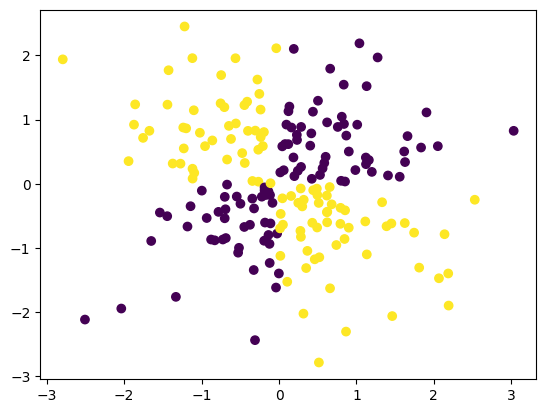

In [188]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# helper function to plot decision boundaries
def plot_decision_regions(X, y, classifier, resolution=0.02, axis=None):
    if X.shape[1] != 2:
        raise ValueError(
            f'Die Daten dürfen maximal 2 Features besitzen. Es wurden aber Daten mit {X.shape[1]} Features übergeben.')
    axis = axis if axis is not None else plt.gca()

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    Zmax = np.abs(Z).max()
    axis.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap, levels=[-Zmax, 0, Zmax])
    axis.set_xlim(xx1.min(), xx1.max())
    axis.set_ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        axis.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                     alpha=0.8, c=np.expand_dims(cmap(idx), 0),
                     marker=markers[idx], label=cl)

# function to generate the data set
def get_data():
    # create data set with training and test set
    np.random.seed(1)
    X = np.random.randn(300, 2)
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
    y = np.where(y, 1, -1)

    # split data
    X_train = X[:200, :]
    y_train = y[:200].reshape(-1, 1)

    X_test = X[200:, :]
    y_test = y[200:].reshape(-1, 1)

    return X_train, y_train, X_test, y_test

# X_train: (N x d) matrix containing N feature vectors with d features each
X_train, y_train, X_test, y_test = get_data()

# visualize data
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

(3) Wie viele Featurevektoren ($N$) hat Ihr Trainingsdatensatz? Wie viele Features ($D$) hat jeder Featurevektor?

In [189]:
print('Es gibt N = {} Featurevektoren/Datenpunkte im Trainingsdatensatz mit je D = {} einzelnen Features.'.format(*X_train.shape))

Es gibt N = 200 Featurevektoren/Datenpunkte im Trainingsdatensatz mit je D = 2 einzelnen Features.


(4) Der Gaußsche RBF-Kernel für zwei Vektoren $\mathbf{x}$ und $\mathbf{x}^\prime$ ist definiert als:

$$K(\mathbf{x},\mathbf{x}^\prime) := \exp \left( -\frac{ \lVert \mathbf{x} - \mathbf{x}^\prime\rVert^2}{2\sigma^2} \right)$$

Implementieren Sie nun die Kernel**matrix** $K$ für einen Gaußschen RBF-Kernel: Schreiben Sie dazu eine Funktion `kernel_rbf`, die drei Argumente entgegennimmt: $X$, $X^\prime$ und $\sigma$. 

- $X$ sei ein $N_1\times D$ Array.
- $X^\prime$ sei ein $N_2\times D$ Array.

Die Arrays enthalten also $N_1$ bzw. $N_2$ Featurevektoren.

Ihre Funktion `kernel_rbf` gibt die Kernelmatrix $K$ zurück. Es handelt sich um eine $N_1 \times N_2$ Matrix.

- Tipp: Vielleicht hilft Ihnen [diese Funktion](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) bei Ihrer Implementierung.

In [190]:
from scipy.spatial import distance

# Die Funktion distance.cdist(XA, XB, metric='euclidean') ermöglicht eine Art elementweises np.linalg.norm(XA - XB), welches hier nicht funktionieren würde, da XA - XB = 0 wäre.
def kernel_rbf(X: np.ndarray, X_dash: np.ndarray, sigma: float) -> np.ndarray:
    return np.exp(- (distance.cdist(X, X_dash, metric='euclidean') ** 2) / (2 * (sigma ** 2)))

kernel_rbf(X_train, X_train, 1)


array([[1.00000000e+00, 8.86531851e-02, 1.79842228e-01, ...,
        1.12196527e-02, 6.82084806e-04, 6.20158683e-03],
       [8.86531851e-02, 1.00000000e+00, 1.78044108e-01, ...,
        1.54795697e-01, 5.54825860e-02, 5.57759008e-03],
       [1.79842228e-01, 1.78044108e-01, 1.00000000e+00, ...,
        1.39654527e-03, 1.30907890e-04, 3.95002113e-05],
       ...,
       [1.12196527e-02, 1.54795697e-01, 1.39654527e-03, ...,
        1.00000000e+00, 6.90538507e-01, 2.58557288e-01],
       [6.82084806e-04, 5.54825860e-02, 1.30907890e-04, ...,
        6.90538507e-01, 1.00000000e+00, 9.10105654e-02],
       [6.20158683e-03, 5.57759008e-03, 3.95002113e-05, ...,
        2.58557288e-01, 9.10105654e-02, 1.00000000e+00]])

(5) Die Kernelmatrix muss die Dimension $N_1 \times N_2$ besitzen. Prüfen Sie mithilfe Ihrer Trainingsdaten `X_train` und `X_test`, ob Ihre Kernelmatrix die richtige Dimension aufweist:

- Welche Dimensionalität erwarten Sie für die Kernelmatrix, die Sie auf den Trainingsdaten berechnen? (`kernel_rbf(X_train, X_train, 1)`)?

- Welche Dimensionalität erwarten Sie für die Kernelmatrix, die Sie auf den Trainings- und Testdaten berechnen? (`kernel_rbf(X_train, X_test, 1)`)?

Wenn Ihre Kernel-Matrix nicht die Dimension aufweist, die Sie erwarten, gehen Sie zu Schritt (4) zurück und überprüfen Ihre Implementierung.

Die Kernelmatrix weist die Dimension $N_1 \times N_2$, also auf den Trainingsdaten $200\times 200$, und auf den Trainings- und Testdaten $200\times 100$. 

In [191]:
print(X_test.shape)
print(X_train.shape)
print(kernel_rbf(X_train, X_train, 1).shape)
print(kernel_rbf(X_train, X_test, 1).shape)

(100, 2)
(200, 2)
(200, 200)
(200, 100)


(6) Implementieren Sie nun eine Funktion `omega(X, y, sigma)`, die einen $N\times 1$ dimensionalen Labelvektor $\mathbf{y}$ sowie ein $N\times D$ Array `X` mit Featurevektoren sowie $\sigma$ entgegennimmt, und die Matrix $\Omega$ zurückgibt:

$$ \Omega = \mathbf{y}\mathbf{y}^\text{T}\odot K$$

Beachten Sie:

- $\mathbf{y}\mathbf{y}^\text{T}$ ist ein [äußeres (=dyadisches) Produkt](https://de.wikipedia.org/wiki/Dyadisches_Produkt), welches eine Matrix erzeugt.
- $\odot$ bedeutet: Es werden die Elemente der beiden Matrizen elementweise multipliziert ([Hadamard-Produkt](https://de.wikipedia.org/wiki/Hadamard-Produkt)). Dies ist also keine normale Matrixmultiplikation.
- $K$ ist die Kernelmatrix, die Sie mit dem Aufruf `kernel_rbf(X, X, sigma)` erzeugen.

Tipp:

- Diese [Funktion](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html) könnte für Sie nützlich sein.

In [192]:
def omega(X: np.ndarray, y: np.ndarray, sigma: float = 1) -> np.ndarray:
    dyadisches_produkt: np.ndarray = y @ y.T
    kernelmatrix: np.ndarray = kernel_rbf(X, X, sigma)
    return np.multiply(dyadisches_produkt, kernelmatrix)

(7) Betrachten Sie die Definition von $\Omega$ aus Schritt (6): Welche Dimensionalität muss $\Omega$ haben? Prüfen Sie nach, ob der Aufruf `omega(X_train, y_train, 1)` eine Matrix mit der von Ihnen erwarteten Dimensionalität zurückgibt.

- Wenn Sie einen Widerspruch zu Ihren Erwartungen feststellen, gehen Sie zu Schritt (6) zurück und überprüfen Ihre Implementierung.

In [193]:
# Die Dimensionalität muss die gleiche der Kernel Matrix sein, also 200 x 200 
omega(X_train, y_train, 1).shape

(200, 200)

(8) Betrachten Sie nun das folgende Gleichungssystem:

$$
	\underbrace{\left[
	\begin{array}{c|c}
		0 & \mathbf{y}^\text{T} \\
		\hline
		\mathbf{y} & \Omega + I/\gamma
	\end{array}
	\right]}_{A}
	\underbrace{\left[
	\begin{array}{c}
		b \\
		\hline
		\vec{\alpha}
	\end{array}
	\right]}_{\mathbf{s}}
	=
	\underbrace{\left[
	\begin{array}{c}
		0 \\
		\hline
		\mathbf{1}
	\end{array}
	\right]}_{\mathbf{z}}
$$

Implementieren Sie nun die Matrix `A`. Damit Sie Ihre Implementierung testen können, setzen Sie beispielhaft für die Daten `X_train`, `y_train` sowie für die Parameter `sigma=1` und `gamma=1` ein. Nutzen Sie Ihre Funktion `omega`, die Sie in Schritt (6) implementiert hatten.

Hinweis:

- Nutzen Sie [np.block](https://numpy.org/doc/stable/reference/generated/numpy.block.html), um die Blockstruktur der Matrix $A$ zu erzeugen, sowie [np.identity](https://numpy.org/doc/stable/reference/generated/numpy.identity.html), um die Identitätsmatrix $I$ zu erzeugen.

In [194]:
def matrix_a(X: np.ndarray[200, 2], y: np.ndarray[200, 1], sigma: float = 1.0, gamma: float = 1.0) -> np.ndarray[201, 201]:
    N = X.shape[0] # 200
    return np.block([
        [0, y.T],
        [y, omega(X, y, sigma) + (1/gamma) * np.identity(N)]
    ])

matrix_a(X_train, y_train, 1).shape

(201, 201)

(9) Prüfen Sie die Dimensionalität Ihrer Matrix `A`. Hat Sie für die Trainingsdaten aus Schritt (8) die Form $(N_{train}+1)\times (N_{train}+1)$? Falls ja, können Sie fortfahren. Falls nein, gehen Sie bitte zu Schritt (8) und überprüfen Ihre Implementierung.

Jo, hat sie. :+1:

(10) Implementieren Sie nun testweise den Vektor $\mathbf{z}$ aus folgendem Gleichungssystem für die Trainingsdaten:

$$
	\underbrace{\left[
	\begin{array}{c|c}
		0 & \mathbf{y}^\text{T} \\
		\hline
		\mathbf{y} & \Omega + I/\gamma
	\end{array}
	\right]}_{A}
	\underbrace{\left[
	\begin{array}{c}
		b \\
		\hline
		\vec{\alpha}
	\end{array}
	\right]}_{\mathbf{s}}
	=
	\underbrace{\left[
	\begin{array}{c}
		0 \\
		\hline
		\mathbf{1}
	\end{array}
	\right]}_{\mathbf{z}}
$$

Tipps:

- Vielleicht sind für Sie [diese Funktion](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) und [jene Funktion](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) bei der Implementierung hilfreich.

- Testen Sie, ob Sie $\mathbf{z}$ richtig implementiert haben mit Ihren Trainingsdaten. Der Vektor $\mathbf{z}$ muss die Dimensionalität $(N_\text{train}+1)\times 1$ aufweisen. Überarbeiten Sie Ihren Code, bis dies der Fall ist.

In [195]:
def z(N: int) -> np.ndarray:
    return np.vstack((np.zeros((1, 1)), np.ones((N, 1))))

z(200).shape

(201, 1)

(11) Berechnen Sie den Lösungsvektor $\mathbf{s}$ aus, indem Sie die Inverse der Matrix A bestimmen:

$$\mathbf{s} = \left[
	\begin{array}{c}
		b \\
		\hline
		\vec{\alpha}
	\end{array} 
	\right] = A^{-1} \mathbf{z}$$
    
Tipps:

- Hier können Ihnen [diese Funktion](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) und [jene Funktion](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) hilfreich sein.
- Für Ihre Trainingsdaten muss der Vektor $\mathbf{z}$ die Dimension $(N_\text{train}+1)\times 1$ aufweisen. Prüfen Sie dies!

In [196]:
# @question: Wieso ist hier auf np.dot verwiesen, wenn ich doch eine Matrixmultiplikation habe? 
def s(A):
    N = A.shape[0] - 1
    return np.linalg.pinv(A) @ z(N)

s(matrix_a(X_train, y_train)).shape

(201, 1)

(12) Gewinnen Sie aus dem Lösungsvektor $\mathbf{s}$ aus dem vorherigen Schritt die Parameter `b` ($b$) und `alpha` ($\vec{\alpha}$).

In [197]:
b, alpha = np.vsplit(s(matrix_a(X_train, y_train)), [1])
print(b, alpha)

[[0.04755365]] [[ 0.13255867]
 [-0.13058846]
 [ 0.14888855]
 [ 0.03598254]
 [ 0.79063492]
 [-0.00839804]
 [ 0.51855324]
 [-0.46611326]
 [ 0.56982059]
 [ 0.71360048]
 [-0.36158403]
 [-0.05783032]
 [-0.19726164]
 [ 0.66809233]
 [ 0.84587649]
 [ 0.22767727]
 [-0.22646268]
 [ 0.82715674]
 [ 0.53387923]
 [-0.17868788]
 [ 0.52620361]
 [-0.1031933 ]
 [ 0.94215388]
 [ 0.90728385]
 [ 0.59261009]
 [ 0.69960274]
 [ 0.341763  ]
 [ 0.90071334]
 [-0.36494073]
 [ 0.29383277]
 [-0.20575694]
 [ 0.57112742]
 [ 0.94416364]
 [-0.20400425]
 [ 0.08086135]
 [ 0.26553996]
 [ 0.51837114]
 [ 0.59739607]
 [ 0.60461945]
 [ 0.3954754 ]
 [ 0.71630954]
 [ 0.57920768]
 [ 0.78046107]
 [ 0.55505269]
 [ 0.65443299]
 [ 0.45543407]
 [ 0.28431362]
 [ 0.80514886]
 [ 1.15435521]
 [ 0.22197855]
 [ 0.18937434]
 [ 0.21692502]
 [ 0.66577179]
 [-0.29509497]
 [ 1.16927567]
 [ 0.32477636]
 [-0.32722136]
 [ 0.32133768]
 [ 0.79947379]
 [ 0.03929955]
 [ 0.90595431]
 [ 0.15674283]
 [-0.00279834]
 [ 0.21215883]
 [-0.28018735]
 [ 0.62085

(13) Implementieren Sie nun eine Funktion mit dem Namen `lssvm(X, y, sigma, gamma)`, die Ihre Schritte (8) bis (12) kombiniert. Ihre Funktion nimmt die allgemeinen Featurevektoren (Datenarray) `X` sowie den dazugehörigen Labelvektor `y` und die Parameter `sigma` und `gamma` entgegen, und gibt die Parameter `alpha` und `b` zurück:

`alpha, b = lssvm(X, y, sigma, gamma)`

Hinweis:

- Achten Sie darauf, dass Sie die Schritte (8) bis (12) nun allgemein ausformulieren, also dass Sie nicht mehr mit den konkreten Trainingsdaten arbeiten. 

In [198]:
def omega(X: np.ndarray, y: np.ndarray, sigma: float = 1) -> np.ndarray:
    dyadisches_produkt: np.ndarray = y @ y.T
    kernel_matrix: np.ndarray = kernel_rbf(X, X, sigma)
    return np.multiply(dyadisches_produkt, kernel_matrix)
    
def lssvm(X: np.ndarray, y: np.ndarray, sigma: float = 1, gamma: float = 1.0) -> tuple[np.ndarray, int]:
    N: int = X.shape[0]
    matrix_A: np.ndarray = np.block([
        [0, y.T],
        [y, omega(X, y, sigma) + (1/gamma) * np.identity(N)]
    ])
    vector_z: np.ndarray = np.vstack((np.zeros((1, 1)), np.ones((N, 1))))
    vector_s: np.ndarray = np.linalg.pinv(matrix_A) @ vector_z

    b, alpha = np.vsplit(vector_s, [1])
    return alpha, b

alpha_2, b_2 = lssvm(X_train, y_train)
if b == b_2 and alpha.all() == alpha_2.all():
    print("Works")

Works


(14) Implementieren Sie nun die Funktion `predict(X_train, X_test, y_train, alpha, b, sigma)`, die die vorhergesagten Labels `y` für die Testdaten `X_test` zurückgibt.

Die durch die LS-SVM vorhergesagten Labels erhalten Sie über:

$$ y(x) = \text{sign} \left[\sum_{k=1}^N \alpha_k y_k K(x_k, x) + b \right] $$

Hinweise:

- Ihre `predict` Funktion gibt einen Labelvektor $\mathbf{y}$ der Dimension $(N_\text{test}\times 1)$ zurück. Dies bedeutet, Ihre Funktion bestimmt für jeden Featurevektor in `X_test` das vorhergesagte Label.
- Rufen Sie in Ihrer `predict` Funktion Ihre vor einigen Schritten selbst implementierte `kernel_rbf` Funktion auf.
- **Wichtig:** Ihre `predict` Funktion wird in der nachfolgenden Teilaufgabe indirekt sehr häufig aufgerufen, um die Entscheidungsgrenzen Ihrer LS-SVM zu visualisieren. Dazu muss `predict` effizient implementiert werden: Vermeiden Sie bei der Implementierung von `predict` die Nutzung von Schleifen. Nutzen Sie stattdessen Funktionalität von *numpy*, mit der Sie Vektoroperationen direkt ausführen lassen können, wie z.B. [multiply](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html). Dieses sogenannte vektorisierte Ausführen ist deutlich schneller als die Ausführung von Schleifen. Wenn Sie diesen Hinweis nicht beachten, dann kann die Berechnung der nächsten Teilaufgabe viele (>15) Minuten dauern.

Sei $$
\text{esign} : \begin{cases}
    \mathbb{R}^{m\times n} \to \{0, 1\}^{m\times n} \\
    A \mapsto \left( \text{sign}(a_j) \right)_{a_j\in A}      
\end{cases}$$
also die Elementweise Signumsfunktion, sowie $\oplus$ die elementweise Addition, so ist der Labelvektor $\mathbf{y}$ gleich
$$
    \mathbf{y} = \text{esign}\left( ( \alpha \odot y )^T K \oplus b \right)^T
$$

In [199]:
def predict(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, alpha: np.ndarray, b: float, sigma: float) -> np.ndarray:
    return np.sign(np.multiply(alpha, y_train).T @ kernel_rbf(X_train, X_test, sigma) + b).T

predict(X_train, X_test, y_train, alpha, b, 1).shape

(100, 1)

(15) Testen Sie Ihre Implementierung, indem Sie die untere Code-Zelle ausführen:

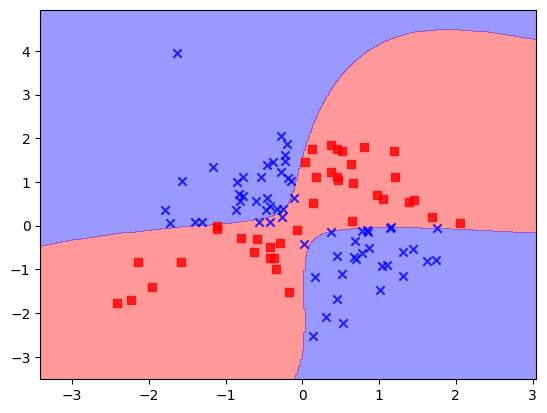

In [200]:
# select hyperparameters
sigma = np.sqrt(2)
gamma = 1

#train model (aquire lagrangian parameters)
alpha, b = lssvm(X_train, y_train, sigma, gamma)

# necessary to emulate the class like structure for "classifier.predict" in plot_decision_regions
lssvm.predict = lambda x: predict(X_train, x, y_train, alpha, b, sigma)

# plot decision regions
plot_decision_regions(X_test, y_test.ravel(), lssvm)
plt.show()

(16) \[Optional\] Testen Sie beispielhaft, wie sich die Entscheidungsgrenze für unterschiedliche Wahl des Kernel-Parameters `sigma` und für den Strafterm `gamma` verändert.

In [201]:
import math
from ipywidgets import interact, widgets
%matplotlib qt
gamma_slider = widgets.FloatLogSlider(
    value=1.0, step=0.1,
    min=-5, max=2,
    readout_format='.5f',
    description='Gamma:'
)

@interact(gamma=gamma_slider)
def run_plot(gamma):
    # gamma = 1/(2*(sigma ** 2))
    sigma = math.sqrt(1 / 2 * gamma) 
    plt.clf()
    alpha, b = lssvm(X_train, y_train, sigma, gamma)
    lssvm.predict = lambda x: predict(X_train, x, y_train, alpha, b, sigma)
    plot_decision_regions(X_test, y_test.ravel(), lssvm)
    plt.title('$\sigma = {}, \gamma = {}$'.format(sigma, gamma))
    plt.show()


interactive(children=(FloatLogSlider(value=1.0, description='Gamma:', max=2.0, min=-5.0, readout_format='.5f')…

Bei einer Least Squares Support Vector Machine (LS-SVM) sind die Parameter Sigma $\sigma$ und Gamma $\gamma$ im Kontext des Gaußschen Radialen Basisfunktionskerns (RBF) zu betrachten. Der Gaußsche RBF Kernel wird allgemein durch die Formel $$
K_{\text{RBF}}(x, x') = \exp\left( - \frac{|| x - x' ||^2}{2\sigma^2} \right) = \exp\left( - \gamma || x - x' ||^2 \right), \quad \gamma > 0
$$ beschrieben, wobei $\gamma = \frac{1}{2\sigma^2}$

- **Gamma $\gamma$**: Dieser Parameter steuert die Breite der RBF-Kernel-Funktion. Ein hoher Wert von $\gamma$ bewirkt, dass der Einfluss eines einzelnen Trainingsbeispiels nur in einem engen Bereich um das Beispiel herum spürbar ist, was zu komplexeren Entscheidungsgrenzen führen kann. Das kann wiederum zu Overfitting führen, insbesondere wenn $\gamma$ zu groß gewählt wird. Umgekehrt führt ein niedriger Wert von $\gamma$ zu breiteren, glatteren Entscheidungsgrenzen, was möglicherweise die Modellkomplexität verringert und somit zu einer besseren Generalisierung beitragen kann.

- **Sigma ($\sigma$)**: Sigma bestimmt im Wesentlichen die Skala, auf der Distanzen zwischen Punkten im Inputraum gemessen werden. Ein kleiner Wert von $\sigma$ bedeutet, dass Punkte, die nicht sehr nahe beieinander liegen, als sehr unterschiedlich betrachtet werden. Dies kann zu einer feineren Anpassung an die Trainingsdaten führen, mit dem Risiko von Overfitting. Ein größerer Wert von $\sigma$ lässt das Modell Unterschiede zwischen Punkten, die weiter voneinander entfernt sind, ignorieren, was zu einer glatteren Entscheidungsgrenze führt.

Damit darf ich Ihnen gratulieren! Sie haben erfolgreich die LS-SVM implementiert.